<a href="https://colab.research.google.com/github/DevCielo/VAE-Transformer/blob/main/Anomaly_Detection_and_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO:
Doesnt generalise well to stocks that increase alot or decrease alot very quickly. This is especially evident with the AAPL stock

# Anomaly Detection
The code in this section builds a time-series anomaly detection system using Variational Autoencoders (VAE) for financial data. More specifically, the VAE learns to reconstruct normal sequences of data and high reconstruction errors signal potential anomalies.

In this section we detect unusual patterns in the stock price data for apple (AAPL) using VAE. Anomalies could indicate significant market events, irregular activity or shifts in price trends.



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
import shap

First we set the seeds for reproducibility so similar results can be obtained for everyone.

In [4]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Before doing any anomaly detection we first want to enhance the raw stock data by adding derived technical indicators to provide richer information about price movements, trends, and momentum. We essentially do this to give the VAE richer information to learn patterns and detect anomalies effectively.

We define two helper functions:

- `compute_RSI` computes the relative strength index (RSI) which measures the speed and magnitude of price changes. Scales from 0 to 100. When RSI > 70 it usually indicated overbought when RSI < 30 it indicates oversold.

- `add_technical_features` enriches dataset with technical indicators that provide insights into price trends and momentum.

In [5]:
def compute_RSI(series, window=14):
    """
    Compute the Relative Strength Index (RSI).
    RSI is a momentum oscillator that measures the speed
    and change of price movements.
    """
    # Calculate daily price changes
    delta = series.diff()

    # Seperate gains and losses
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    # Computes average gain and loss over a 14 day rolling window
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    # calculates relative strength and RSI
    rs = avg_gain / (avg_loss + 1e-9)  # avoid div-by-zero
    rsi = 100 - (100 / (1 + rs))
    return rsi

def add_technical_features(df):
    """
    Add some simple technical indicators to enrich the feature space:
      - 7-day moving average of Close (MA7)
      - 21-day moving average of Close (MA21)
      - RSI(14)
    """
    df['MA7'] = df['Close'].rolling(window=7).mean() # Average closing price over past 7 days (short-term fluctuations)
    df['MA21'] = df['Close'].rolling(window=21).mean() # Average closing price over past 21 days (long-term trends)
    df['RSI14'] = compute_RSI(df['Close'], window=14)

    # Moving averages and RSI require a window of data for computation resulting in NaN at the start
    # We drop these NaN values below
    df.dropna(inplace=True)
    return df

After this the enriched data frame includes:
- Raw: Open, High, Low, Close, Volume
- Derived: MA7, MA21, RSI14

Now that we have defined these helper functions lets acquire and prepare the financial data. In this case we use Apple stocks but any stock can be used.

In [6]:
ticker = 'AAPL' # Change stock here if youd like to test on a different stock.

# Fetches 8 years of stock data for Apple
full_start_date = '2015-01-01'
full_end_date = '2023-01-01'

# Downloads the historical stock data
print("Downloading data...")
df_full = yf.download(ticker, start=full_start_date, end=full_end_date)
df_full = df_full[['Open', 'High', 'Low', 'Close', 'Volume']]
df_full.dropna(inplace=True) # handles missing data (weekends/holidays)
print(f"Initial Data Shape: {df_full.shape}")

# Adds Additional Features (MAs, RSI)
df_full = add_technical_features(df_full)
print(f"Data Shape after adding features: {df_full.shape}")

[*********************100%***********************]  1 of 1 completed

Initial Data Shape: (2014, 5)
Data Shape after adding features: (1994, 8)


After this we split the dataset into training and testing subsets. IN this case we use a rolling window because:
- Time-series models require temporally consistent training/testing data
- It ensures the model only learns patterns fro the past to predict future trends preserving the authenticity of evaluation
- It mimics a real-world scenario where the model is trained on historical data and deployed to make predictions about future data.


In [7]:
# Training Set: January 1, 2015 to January 1, 2021
# Test set: January 2, 2021 to January 1, 2022
train_start_date = '2015-01-01'
train_end_date   = '2021-01-01'
test_start_date  = '2021-01-02'
test_end_date    = '2022-01-01'

# Subsets data
train_df = df_full.loc[train_start_date:train_end_date].copy()
test_df  = df_full.loc[test_start_date:test_end_date].copy()

print(f"\nTraining set range: {train_df.index[0].date()} to {train_df.index[-1].date()} => {train_df.shape[0]} rows")
print(f"Testing set range : {test_df.index[0].date()} to {test_df.index[-1].date()} => {test_df.shape[0]} rows")


Training set range: 2015-02-02 to 2020-12-31 => 1491 rows
Testing set range : 2021-01-04 to 2021-12-31 => 252 rows


Next we define the hyperparameters for the VAE to control how the model is trained and how data is structured and anomalies are identified. These are not necessarily optimal and were picked after about a day of testing different hyperparams (so please try different ones and see how it goes)

The parameters are:
- `sequence_length`: Defines number of time steps in each input sequence to VAE. Time series is processed in sequences. A sequence length of 5 means 5 consecutive days of data. A short sequence length captures local patterns and trends in time-series data but too small can be computationally expensive
- `batch_size`: Specifies number of sequences processed in single forward/backward pass during training. Larger batches stabilize training but require more memory. Smaller batches introduce noise but often generalize better.
- `learning_rate`: Controls step size of optimizer when updating model params. Lower value can take longer but ensures gradual updates and reducing the risk of overshooting minima. Too high leads to unstable training but can speed up if picked right.
- `num_epochs`: Max number of passes through training dataset.
- `beta`: Balances tradeoff between reconstruction loss and latent space regularization in VAE loss function. Reconstruction loss measures how well model reconstructs the input sequences. KL Divergence ensures latent space follows a Gaussian distribution. Beta scales the KL divergence term. Values closer to 1 emphasize latent space regularization (so useful for generative tasks). Values closer to 0 prioritize reconstruction.
- `teacher_forcing_prob`: Controls probability of using teacher forcing during training. Teacher forcing means feeding ground-truth input into the decoder at next time step. This helps decoder learn effectively during early stages fo training. Prob of 0.5 means model uses teacher forcing 50% of time during training. This balances exploration (using model outputs) and exploitation (using ground truths) during training.
- `anomaly_percentile`: Defines threshold for identifying anomalies based on reconstruction errors. Extremely high threshold is chosen to ensure only rare/extreme deviations are classified as anomalies.

In [8]:
sequence_length = 5
batch_size = 64
learning_rate = 1e-4
num_epochs = 100
beta = 0.85 # Value seemed to have a big effect on anomaly detection so please try different values to test.
teacher_forcing_prob = 0.5
anomaly_percentile = 99.99999

Next we prepare the sequential input data for the VAE by converting raw time-series data into fixed-length overlapping sequences. These sequences are used as input to the model for training/testing. By putting data into sequences we can capture temporal dependency and ensures data is compatible wwith the format (batch_size, seq_length, features) (which is required by VAE). Essentially by including information from past time steps the model can better reconstruct patterns and identify anomalies.

In [9]:
# data_array is array of shape (N, features) where N = number of time steps, features = number of features per time step (Open, close, rsi14 etc.)
def create_sequences(data_array, seq_length):
    sequences = []
    # Iterates through data creating slices of length 5 e.g. sequence 1: Rows 0 to 4, sequence 2: rows 1 to 5, sequence 3: rows 2 to 6 etc.
    for i in range(len(data_array) - seq_length):
        seq = data_array[i : i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Converts data frames to numpy arrays
train_array = train_df.values  # shape: (N_train, 8)
test_array  = test_df.values   # shape: (N_test, 8)


Now we normalize data using MinMaxScaler and converting it into scaled sequences for training/testing the model. Scaling ensures all features have same range improving the model performance and stability during training.

In this case we use the MinMaxScaler(). This scales each feature to a specified range (usually [0, 1]) using the formula:
$$
X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$$




In [10]:
scaler = MinMaxScaler()
scaler.fit(train_array) # Computes min and max values for each feature in training set (test set not considered to avoid data leakage)

# Scales training and testing data using min/max values computed (should result in a numpy array with all features values between 0 and 1)
train_scaled = scaler.transform(train_array) # (N_train, 8)
test_scaled  = scaler.transform(test_array) # (N_test, 8)

# Converts scaled data into fixed-length sequences
train_sequences = create_sequences(train_scaled, sequence_length)
test_sequences  = create_sequences(test_scaled, sequence_length)

# Debugging
print(f"train_sequences shape: {train_sequences.shape}")
print(f"test_sequences  shape: {test_sequences.shape}")

train_sequences shape: (1486, 5, 8)
test_sequences  shape: (247, 5, 8)


Next we create PyTorch Dataset and Dataloader for managing time-series data during training/testing. This handles batching, shuffling and efficient data loading for us.

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = torch.tensor(sequences, dtype=torch.float32) # Converts input sequences into a PyTorch tensor

    def __len__(self):
        return len(self.sequences) # Number of sequences in dataset

    def __getitem__(self, idx):
        return self.sequences[idx] # Fetches sequence at a specific index

train_dataset = TimeSeriesDataset(train_sequences)
test_dataset  = TimeSeriesDataset(test_sequences)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debugging
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size:  {len(test_dataset)}")

Train dataset size: 1486
Test dataset size:  247


Next we define the VAE model using LSTMs to:
1. Encode the time-series sequences into a lower-dimensional latent space (Encoder)
2. Reconstruct the input sequences form this latent representation (Decoder)
3. Learn meaningful latent representations that capture the underlying structure of data.

In [12]:
class VAE(nn.Module):
    """
    A VAE with:
      - 4-layer LSTM encoder/decoder
      - hidden_dim (256)
      - latent_dim (64)
      - Optional partial teacher forcing
    """
    def __init__(
        self,
        input_dim=8, # No. of features
        hidden_dim=256, # No. of units in LSTM layers
        latent_dim=64, # Size of latent space
        num_layers=4, # No. of LSTM layers in encoder and decoder
        dropout=0.2, # Dropout probability for regularization
        teacher_forcing_prob=0.5, # Prob of applying teacher forcing during decoding
        beta=0.5 # Weight for KL divergence term
    ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.beta = beta
        self.teacher_forcing_prob = teacher_forcing_prob

        # Encoder to process input sequence and generate a hidden state representation (captures info about input sequence).
        self.encoder_lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Computes the mean (mu) and log-variance (logvar) of latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(
            hidden_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Maps decoder outputs to feature space
        self.output_layer = nn.Linear(hidden_dim, input_dim)

        # Converts input features to hidden dimension during teacher forcing
        self.feature2hid = nn.Linear(self.input_dim, self.hidden_dim)

    # Passes input sequence x through encoder LSTM -> Extracts hidden state of top LSTM layer -> Computes mu and logvar
    def encode(self, x):
        _, (h_n, _) = self.encoder_lstm(x)
        h_n = h_n[-1]  # top layer's hidden state -> (batch, hidden_dim)
        mu = self.fc_mu(h_n)
        logvar = self.fc_logvar(h_n)
        return mu, logvar

    # Reparameterization trick to enable backprop through stochastic latent space
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar) # Computes std from logvar
        eps = torch.randn_like(std) # Sample noise from standard normal distribution
        return mu + eps * std # Generates latent vector

    # Decodes latent vector z back into a reconstructed sequence
    def decode(self, z, seq_length, x=None):
        batch_size = z.size(0)
        # Maps Z to initial hidden state of decoder
        h = self.fc_decode(z)  # (batch, hidden_dim)
        # reshapes to fit dimensions expected by LSTM
        h = h.unsqueeze(0).repeat(self.num_layers, 1, 1)  # (num_layers, batch, hidden_dim)
        c = torch.zeros_like(h)

        dec_input = torch.zeros(batch_size, 1, self.hidden_dim, device=z.device) # Initializes decoder input
        # Passes the hidden state through the LSTM decoder for seq_length time steps
        outputs = []
        for t in range(seq_length):
            output, (h, c) = self.decoder_lstm(dec_input, (h, c))
            out = self.output_layer(output)  # (batch, 1, input_dim)
            outputs.append(out)

            # Introduces ground-truth input x into decoding process with probability of 0.5
            # Randomly decides for each sequence in batch whether to use teacher forcing
            use_teacher_forcing = False
            if x is not None:
                teacher_force_mask = torch.rand(batch_size, device=z.device) < self.teacher_forcing_prob
                if teacher_force_mask.any():
                    use_teacher_forcing = True

            if use_teacher_forcing and x is not None:
                real_hidden = self.feature2hid(x[:, t, :].unsqueeze(1))  # (batch, 1, hidden_dim)
                dec_input = torch.where(
                    teacher_force_mask.view(-1,1,1),
                    real_hidden,
                    output
                )
            else:
                dec_input = output

        # Combines outputs
        return torch.cat(outputs, dim=1)  # (batch, seq_length, input_dim)

    # Encodes input sequence to compute mu and logvar -> reparametrize to generate latent vector z -> decodes z to reconstruct the input sequence
    def forward(self, x):
        seq_length = x.size(1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, seq_length, x=x)
        return x_recon, mu, logvar

Next we initialize the VAE model, optimizer, learning rate scheduler and loss function for training.

The loss function combines the:
1. Reconstruction loss (measures how well the reconstructed sequence matches the original sequence) using the MSE as metric:
$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (x_i - \hat{x}_i)^2
$$

2. KL Divergence (Measures how close latent space distribution is to standard Guassian distribution N(0, I)). And ensures latent space is smooth and suitable for sampling using the formula:
$$
\text{KLD} = -0.5 \cdot \text{mean} \left(1 + \log(\sigma^2) - \mu^2 - \sigma^2 \right)
$$



In [13]:
# Checks if a GPU is available for training (to speed up training)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initializes the VAE model
model = VAE(
    input_dim=8,
    hidden_dim=256,
    latent_dim=64,
    num_layers=4,
    dropout=0.2,
    teacher_forcing_prob=teacher_forcing_prob,
    beta=beta
).to(device)

# Initializes the adam optimizer (model.parameters = trainable params, weight_decay is a regularization term to prevent overfitting)
# Adam is used as it combines benefits of momentum (smooths updates) and adaptive learning rates
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Dynamically adjsuts learning rate based on validation loss to help optimizer converge effectively.
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

# Combines the reconstruction loss and the KL Divergence
def loss_function(recon_x, x, mu, logvar, beta=0.5):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Now we train the VAE model using the training data and evalute its performance on the validation set. This process includes:
1. Monitoring training and validation losses
2. Dynamically adjusting learning rate using the ReduceLROnPlateau scheduler which reduces the learning rate by a factor if the metric doesnt improve for a certain no. of epochs.
3. Saving best-performing model based on validation loss
4. Implementing early stopping to prevent overfitting and unnecessary computation.

In [14]:
# Sets up the early stopping variables
patience = 10 # No. of epochs to wait for validation loss improvement before stopping training
patience_counter = 0 # Tracks no. of epochs passed
best_val_loss = float('inf') # Stores lowest observed validation loss

train_losses = []
val_losses = []

# Starts the training loop
print("\nStarting training...")
for epoch in range(1, num_epochs+1):
    model.train() # Puts model in training mode enabling dropout and gradient updates
    running_train_loss = 0.0 # Accumulates total training loss for current epoch

    for batch in train_loader:
        batch = batch.to(device) # Loads batch of training data and moves it to the computation device
        optimizer.zero_grad() # Clears previous gradients to avoid accumulation

        recon_batch, mu, logvar = model(batch) # Forward pass
        loss = loss_function(recon_batch, batch, mu, logvar, beta=model.beta) # Calculates combined loss
        loss.backward() # Backward pass to compute gradients
        optimizer.step() # Update model params

        running_train_loss += loss.item() * batch.size(0) # Adds the loss (scaled by batch size for handling uneven batch sizes (like the last one))

    # Computes average loss across all training samples in epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval() # Puts model in evaluation mode disabling dropout
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device) # Moves batch to device
            recon_batch, mu, logvar = model(batch) # Passes through model to compute values
            val_loss = loss_function(recon_batch, batch, mu, logvar, beta=model.beta) # Calculates loss
            running_val_loss += val_loss.item() * batch.size(0) # Accumulates validation loss

    epoch_val_loss = running_val_loss / len(test_loader.dataset) # Average validation loss across all samples
    val_losses.append(epoch_val_loss) # Appends computed validation loss to val_losses

    scheduler.step(epoch_val_loss) # Adjusts learning rate based on validation loss. If validation loss does not improve learning rate is reduced.

    # Debug logs
    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.6f} | "
          f"Val Loss: {epoch_val_loss:.6f}")

    # Early Stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_vae_model.pth') # Saves model if validation loss improves
        print(f"Validation loss improved to {epoch_val_loss:.6f}. Saving model.")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training complete.")


Starting training...
Epoch 1/100 | Train Loss: 0.112312 | Val Loss: 0.786988
Validation loss improved to 0.786988. Saving model.
Epoch 2/100 | Train Loss: 0.078591 | Val Loss: 0.582973
Validation loss improved to 0.582973. Saving model.
Epoch 3/100 | Train Loss: 0.052821 | Val Loss: 0.530536
Validation loss improved to 0.530536. Saving model.
Epoch 4/100 | Train Loss: 0.044973 | Val Loss: 0.437250
Validation loss improved to 0.437250. Saving model.
Epoch 5/100 | Train Loss: 0.037785 | Val Loss: 0.362312
Validation loss improved to 0.362312. Saving model.
Epoch 6/100 | Train Loss: 0.031566 | Val Loss: 0.288572
Validation loss improved to 0.288572. Saving model.
Epoch 7/100 | Train Loss: 0.026994 | Val Loss: 0.257088
Validation loss improved to 0.257088. Saving model.
Epoch 8/100 | Train Loss: 0.024653 | Val Loss: 0.260427
No improvement for 1 epoch(s).
Epoch 9/100 | Train Loss: 0.024772 | Val Loss: 0.241617
Validation loss improved to 0.241617. Saving model.
Epoch 10/100 | Train Loss: 

Next we plot this training and validation loss.

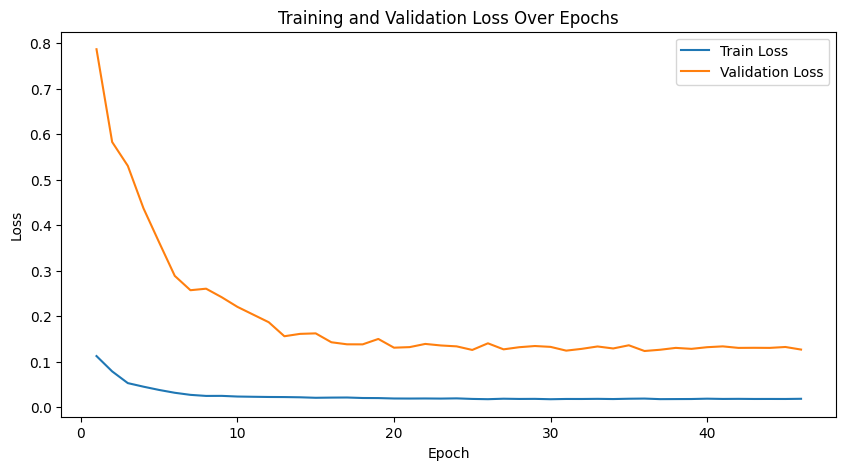

In [15]:
plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

Next we evaluate the reconstruction errors produced by the VAE to quantify how well the model can reconstruct the input sequences (this serves as a basis for identifying anomalies).

In [16]:
# Computes reconstruction errors (MSE) for each sequence in dataset
def get_reconstruction_errors(model, data_loader):
    model.eval() # Evaluation mode
    all_errors = []
    with torch.no_grad(): # Ensures no gradients are computed
        for batch in data_loader:
            batch = batch.to(device)
            recon_batch, mu, logvar = model(batch)
            mse = torch.mean((recon_batch - batch)**2, dim=[1,2]).cpu().numpy() # Calculates MSE and converts tensor to numpy array for easier storage/manipulation
            all_errors.extend(mse) # Adds MSE values for all sequences in the batch to a alist
    return np.array(all_errors)

# Loads the params of the best model
model.load_state_dict(torch.load('best_vae_model.pth', map_location=device))
model.eval()

# Computes reconstruction errors
print("\nCalculating reconstruction errors on train and test sets...")
train_errors = get_reconstruction_errors(model, train_loader)
test_errors  = get_reconstruction_errors(model, test_loader)

# Provides insights into how well model learned to reconstruct sequence
print("\n--- Reconstruction Error Statistics ---")
print(f"Train Errors: Mean={train_errors.mean():.6f}, Std={train_errors.std():.6f}, "
      f"Min={train_errors.min():.6f}, Max={train_errors.max():.6f}")
print(f"Test  Errors: Mean={test_errors.mean():.6f}, Std={test_errors.std():.6f}, "
      f"Min={test_errors.min():.6f}, Max={test_errors.max():.6f}")

<ipython-input-16-61d87088d805>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vae_model.pth', map_location=device))



Calculating reconstruction errors on train and test sets...

--- Reconstruction Error Statistics ---
Train Errors: Mean=0.013913, Std=0.018454, Min=0.000765, Max=0.282373
Test  Errors: Mean=0.075825, Std=0.065617, Min=0.005811, Max=0.452982


Sets a dynamic threshold for anomaly detection based on reconstruction errors. Applies this threshold to test set to identify anomalies. A percentile is used to account for natural distribution of errors in the training data and to adapt to datasets with varying scales of reconstruction errors.

In [17]:
threshold = np.percentile(train_errors, anomaly_percentile) # Computes dynamic threshold based on training reconstruction errors.
print(f"\nDynamic Threshold = {anomaly_percentile}th percentile of Train Errors = {threshold:.6f}")

anomalies = test_errors > threshold # Compares each reconstruction error in test set agains the threshold and flags anomalies that exceeds the threshold
num_anomalies = np.sum(anomalies) # Counts total anomalies
total_test = len(test_errors) # counts total sequences
pct_anomalies = 100.0 * num_anomalies / total_test # percentage of anomalies

print(f"Number of anomalies in test set: {num_anomalies} / {total_test} = {pct_anomalies:.2f}%")


Dynamic Threshold = 99.99999th percentile of Train Errors = 0.282361
Number of anomalies in test set: 4 / 247 = 1.62%


These anomalies can be visualised below.

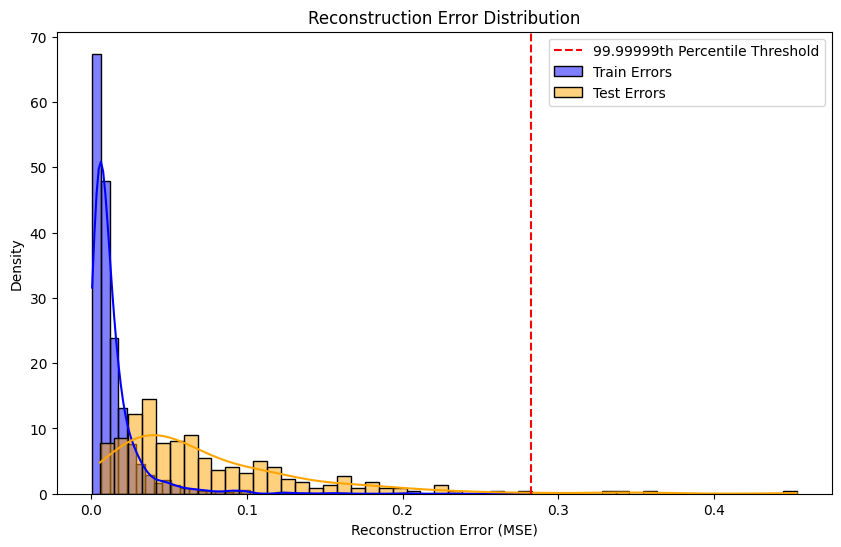

In [18]:
plt.figure(figsize=(10,6))
sns.histplot(train_errors, bins=50, color='blue', kde=True, stat="density", label='Train Errors')
sns.histplot(test_errors, bins=50, color='orange', kde=True, stat="density", label='Test Errors')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'{anomaly_percentile}th Percentile Threshold')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Density')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()

Next we identify the dates corresponding to the detected anomalies in the test set and visuaize these anomalies on the stock's close price chart


Anomaly Dates (in test set):
2021-01-15
2021-08-03
2021-08-10
2021-09-09


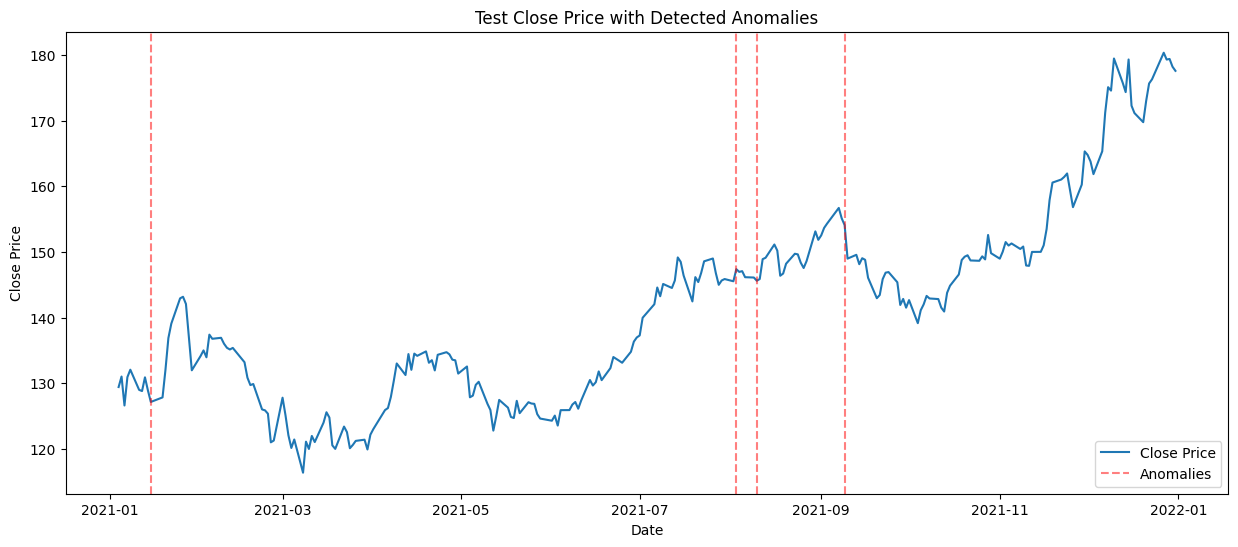

In [19]:
anomaly_indices = np.where(anomalies)[0] # Finds the indices in the anomalies array where value is True

# Determines anomaly dates
anomaly_dates = []
for seq_idx in anomaly_indices:
    final_idx = seq_idx + sequence_length - 1
    if final_idx < len(test_df):
        anomaly_date = test_df.index[final_idx]
        anomaly_dates.append(anomaly_date.date())

print("\nAnomaly Dates (in test set):")
for d in anomaly_dates:
    print(d)

# Plot them on the test set's close price
plt.figure(figsize=(15,6))
plt.plot(test_df.index, test_df['Close'], label='Test Close Price')
for d in anomaly_dates:
    plt.axvline(x=d, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Test Close Price with Detected Anomalies')
plt.legend(['Close Price', 'Anomalies'])
plt.show()

Next we perform inference on a single sequence from the test set to:
1. Evaluate how well the model reconstructs the sequence
2. compute the reconstruction error
3. visualize the original and reconstructed close price features.


Random Test Sequence Index: 102
Reconstruction MSE for this sequence: 0.090851


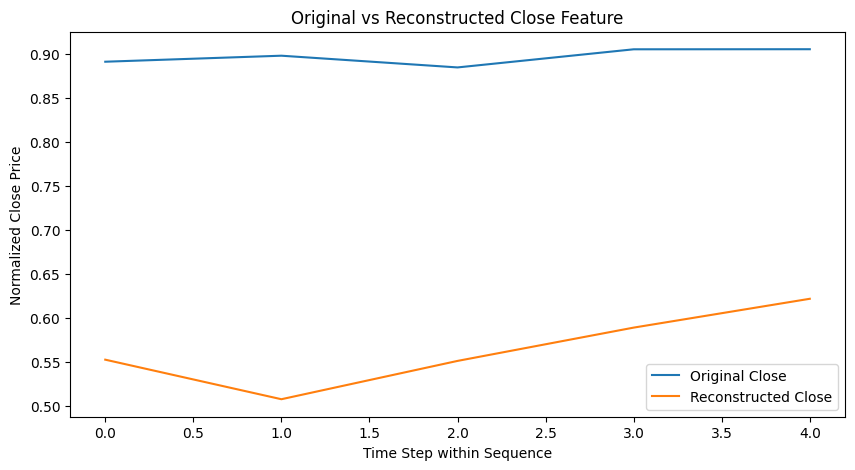

Date Range for this sequence: 2021-06-01 to 2021-06-07


In [20]:
def infer_single_sequence(model, sequence_np):
    """
    Run inference for a single sequence (shape: (seq_length, input_dim)).
    Returns the reconstructed sequence and MSE.
    """
    model.eval()
    seq_tensor = torch.tensor(sequence_np, dtype=torch.float32).unsqueeze(0).to(device) # Converts form numpy array to pytorch tensor
    with torch.no_grad():
        recon, mu, logvar = model(seq_tensor)
    recon = recon.squeeze(0).cpu().numpy() # removes batch dimension to convert to shape (seq_length, input_dim) and converts back to numpy array
    mse = np.mean((recon - sequence_np)**2)
    return recon, mse

# Picks a random test sequence
random_seq_idx = np.random.randint(len(test_sequences))
original_seq = test_sequences[random_seq_idx]
reconstructed_seq, mse_error = infer_single_sequence(model, original_seq)

print(f"\nRandom Test Sequence Index: {random_seq_idx}")
print(f"Reconstruction MSE for this sequence: {mse_error:.6f}")

# Plot only the 'Close' feature (index=3) for clarity
plt.figure(figsize=(10,5))
plt.plot(range(sequence_length), original_seq[:, 3], label='Original Close')
plt.plot(range(sequence_length), reconstructed_seq[:, 3], label='Reconstructed Close')
plt.xlabel('Time Step within Sequence')
plt.ylabel('Normalized Close Price')
plt.title('Original vs Reconstructed Close Feature')
plt.legend()
plt.show()

# Identify the date range for this random sequence
seq_start_idx = random_seq_idx
seq_end_idx = seq_start_idx + sequence_length - 1
if seq_end_idx < len(test_df):
    start_date = test_df.index[seq_start_idx]
    end_date   = test_df.index[seq_end_idx]
    print(f"Date Range for this sequence: {start_date.date()} to {end_date.date()}")
else:
    print("Sequence extends beyond test data range.")

Although we are technically finished, SHAP (Shapley additive explanations) were also incorporated to interpret the high reconstruction error for a single anomaly detected in the test set. Essentially, we use SHAP to provide feautre-level explanations to help understand which features contributed the most to anomalies.

We define an `anomaly_score` then use shap.KernelExplainer to estimate each feature's contribution.


Explaining anomaly at test_sequences index 5


  0%|          | 0/1 [00:00<?, ?it/s]

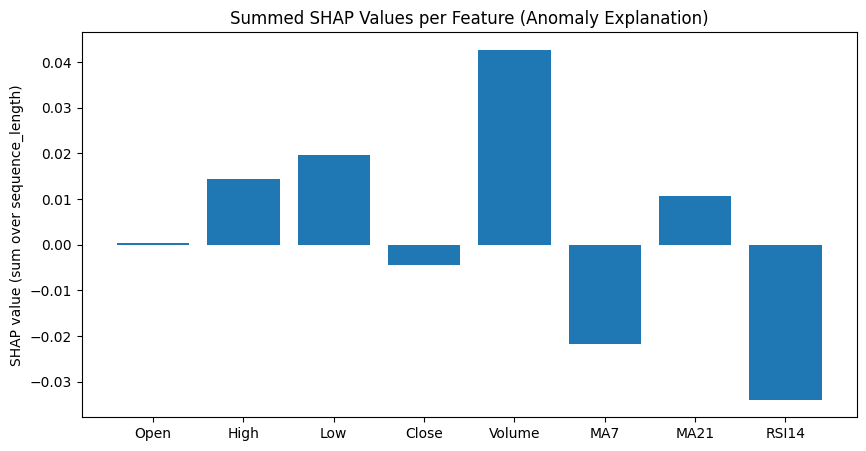

In [21]:
# Computes reconstruction error (MSE)
def anomaly_score(model, inputs_3d):
    """
    inputs_3d shape: (batch, seq_length, input_dim)
    Return a 1D array of anomaly scores (MSE) for each item in the batch.
    """
    with torch.no_grad():
        inputs_t = torch.tensor(inputs_3d, dtype=torch.float32).to(device) # Converts input data to pytorch tensor
        recons, _, _ = model(inputs_t) # passes data through model to obtain recosntructed sequences (recons)
        mse = torch.mean((recons - inputs_t)**2, dim=[1,2]) # Calculates MSE for each sequence in the batch
    return mse.cpu().numpy() # Returns numpy array for MSE

# initializes SHAP
import shap
shap.initjs()

feature_names = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA7', 'MA21', 'RSI14']

# Checks for anomalies
if len(anomaly_indices) > 0:
    # Select first anomaly for demonstration
    first_anomaly_idx = anomaly_indices[0]
    anomaly_seq = test_sequences[first_anomaly_idx]  # shape: (sequence_length, 8)

    print(f"\nExplaining anomaly at test_sequences index {first_anomaly_idx}")

    # Creates small subset of normal sequences to serve as background data for SHAP to help approximate the 'typical' input distribution
    if len(test_sequences) > 20:
        background_indices = np.random.choice(np.where(~anomalies)[0], size=20, replace=False)
    else:
        # if not enough non-anomalies, just pick random
        background_indices = np.random.choice(len(test_sequences), size=min(20,len(test_sequences)), replace=False)

    background_data = test_sequences[background_indices]  # shape: (20, seq_length, 8)

    # Wraps anomaly_score to reshape input data into correct 3d format expected by model.
    def shap_anomaly_wrapper(x):
        # if x arrives flattened we unflatten
        batch_size = x.shape[0]

        # each sample in 'x' is flattened to length seq_length*input_dim
        x_reshaped = x.reshape(batch_size, sequence_length, len(feature_names))

        return anomaly_score(model, x_reshaped)

    # Flatten background for KernelExplainer
    background_data_flat = background_data.reshape(background_data.shape[0], -1)

    # Shap method that uses a simplified model to approximate feature contributions.
    explainer = shap.KernelExplainer(
        shap_anomaly_wrapper,
        background_data_flat
    )

    # Flatten the single anomaly sample for shap
    anomaly_seq_flat = anomaly_seq.reshape(1, -1)

    # Contains SHAP values for each feature across sequence
    shap_values = explainer.shap_values(anomaly_seq_flat, nsamples=100)

    # plot
    shap.force_plot(
        explainer.expected_value,
        shap_values[0],
        anomaly_seq_flat[0],
        feature_names = [f"{f}_t{t}" for t in range(sequence_length) for f in feature_names]
    )

    # Convert shap_values[0] back to shape (seq_length, input_dim)
    shap_values_2d = shap_values[0].reshape(sequence_length, len(feature_names))
    # Sums shap values across time dimnesion to compute overall feature importance
    feature_importances = shap_values_2d.sum(axis=0)

    plt.figure(figsize=(10,5))
    plt.bar(feature_names, feature_importances)
    plt.title("Summed SHAP Values per Feature (Anomaly Explanation)")
    plt.ylabel("SHAP value (sum over sequence_length)")
    plt.show()
else:
    print("No anomalies found, so no SHAP explanations to display.")

# Future Price-Prediction
This implements a time-series forecasting model using an enhanced Transformer architecture to predict future stock prices. It is inspired by the "Attention is all you need."

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

To begin the input data for time-series forecasting must first be prepared. To do this, we organize past stock data into input sequences and corresponding target values, creating datasets for training and testing.

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# forecasting parameters:
forecast_sequence_length = 30 # No. of consecutive time steps in input sequence (X)
future_horizon = 10 # How far into future model predicts

# Converts raw stock data into sequences of inputs (X) and corresponding target (y) (for supervised learning)
def create_forecast_sequences(df, seq_length=30, feature_cols=None, target_col='Close'):
    data_array = df[feature_cols].values # Features (open, high, loW etc.)
    target_array = df[target_col].values # Values of target column (Close)
    X, y = [], [] # sequences of inputs, target

    # Itrates to create sequences
    for i in range(len(df) - seq_length):
        X.append(data_array[i : i + seq_length])
        y.append(target_array[i + seq_length])
    return np.array(X), np.array(y) # To be compatible with ML libraries converts to numpy arrays

feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA7', 'MA21', 'RSI14']
target_col   = 'Close'

X_train, y_train = create_forecast_sequences(train_df,
                                             seq_length=forecast_sequence_length,
                                             feature_cols=feature_cols,
                                             target_col=target_col)

X_test, y_test = create_forecast_sequences(test_df,
                                           seq_length=forecast_sequence_length,
                                           feature_cols=feature_cols,
                                           target_col=target_col)

print("Forecasting dataset shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test : {X_test.shape},  y_test : {y_test.shape}")

Forecasting dataset shapes:
X_train: (1461, 30, 8), y_train: (1461, 1)
X_test : (222, 30, 8),  y_test : (222, 1)


Next scaling is applied to normalize the training and testing datasets to a consistent range, making data more suitable and improve model convergening and stability.

In [24]:
# Reshapes from 3D arrays (num_samples, seq_length, num_features) to 2D (num_samples x seq_length, num_features) as scalers expect 2D inputs
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
X_test_2d = X_test.reshape(-1, X_test.shape[-1])

# Uses MinMaxScaler for range of [0, 1]
X_train_scaled_2d = scaler.transform(X_train_2d)
X_test_scaled_2d = scaler.transform(X_test_2d)

# Restore to 3D shape for transformer model
X_train_scaled = X_train_scaled_2d.reshape(X_train.shape)
X_test_scaled = X_test_scaled_2d.reshape(X_test.shape)

# Converts 1D targets (num_samples,) to 2D (num_samples, 1)
y_train_reshape = y_train.reshape(-1, 1)
y_test_reshape = y_test.reshape(-1, 1)

# Creates temporary thing where each target value is duplicated across all feature dimensions in X_train.
# Done to scale target values consistently within the same feature space.
y_train_scaled = scaler.transform(np.hstack([y_train_reshape]*X_train.shape[-1]))[:, 0]
y_test_scaled = scaler.transform(np.hstack([y_test_reshape]*X_test.shape[-1]))[:, 0]

print(f"After scaling => X_train_scaled: {X_train_scaled.shape}, y_train_scaled: {y_train_scaled.shape}")
print(f"               X_test_scaled : {X_test_scaled.shape} , y_test_scaled : {y_test_scaled.shape}")

After scaling => X_train_scaled: (1461, 30, 8), y_train_scaled: (1461,)
               X_test_scaled : (222, 30, 8) , y_test_scaled : (222,)


Organizes scaled training and test datasets into pytorch-comptaible foramt. Similar to VAE.

In [25]:
class ForecastingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_forecast_dataset = ForecastingDataset(X_train_scaled, y_train_scaled)
test_forecast_dataset  = ForecastingDataset(X_test_scaled, y_test_scaled)

forecast_batch_size = 32
train_forecast_loader = DataLoader(train_forecast_dataset, batch_size=forecast_batch_size, shuffle=True)
test_forecast_loader  = DataLoader(test_forecast_dataset, batch_size=forecast_batch_size, shuffle=False)

Next we define a transformer model for time-series forecasting. It uses:
1. positional encoding to encode temporal order. As transformers don't have sense of order, positional encoding essentially adds temporal information to input embeddings. This follows the sinusoidal positional encoding from "Attention is All You Need":

$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

Where:
- pos: Position in the sequence.
- i: Dimension index.
- dmodel: Total dimension of the model embeddings.

2. transformer encoder layers to model relationships across time steps and features. A larger new transformer architecture is utilized to ensure its tailored towards time-series forecasting.
3. A feedforward layer to output the next closing price


In [26]:
class PositionalEncoding(nn.Module):
    # Same output shape as input shape
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, max_len, d_model)
        self.register_buffer('pe', pe)  # so it's not a learnable parameter

    def forward(self, x):
        seq_len = x.size(1)
        # Add positional encoding to input embeddings
        x = x + self.pe[:, :seq_len, :]
        return x

# Transformer-based model tailored towards time-series forecasting
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim, d_model=256, nheads=8, num_layers=3, dim_feedforward=512, dropout=0.05):
        """
          - d_model=256
          - 8 attention heads
          - 3 encoder layers
          - feedforward dimension=512
          - dropout=0.05 (smaller for a smaller dataset)
        """
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        self.feature_linear = nn.Linear(input_dim, d_model) # Maps input feature to model's internal dimensions (batch_size, seq_length, 8) -> (batch_size, seq_length, 256)
        self.pos_encoder = PositionalEncoding(d_model) # Adds positional encoding to feature embeddings to encode order of time steps

        # Utilizes multi-head self-attention and feedforward layers from Transformer architecture
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nheads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Randomly zeroes out activations for regularization and exploration
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.feature_linear(x) # maps input features to transformers internal dimensions (batch_size, seq_length, d_model)
        x = self.pos_encoder(x) # Adds positional encoding (batch_size, seq_length, d_model)
        x = self.transformer_encoder(x) # Applies the multi-head self-attention and feedforward layers to learn temporal and feature dependencies (batch_size, seq_length, d_model)
        x = x[:, -1, :] # Extracts output corresponding to last time step of sequence (batch_size, d_model)
        x = self.dropout(x)
        out = self.fc_out(x) # Maps final representation to predicted closing price (batch_size, 1)
        return out.squeeze(1)

After definined the model we now train the model, this involves:
1. Defining model, optimizer and loss function and learnign rate scheduler.
2. Training model for a specified number of epochs to minimize MSE loss
3. Tracking / visualizing training and validaiton loss.



Training the Enhanced Transformer Forecast model...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/60] - Train Loss: 0.071534, Val Loss: 0.013827
Epoch [2/60] - Train Loss: 0.018697, Val Loss: 0.004678
Epoch [3/60] - Train Loss: 0.014381, Val Loss: 0.003588
Epoch [4/60] - Train Loss: 0.010699, Val Loss: 0.004820
Epoch [5/60] - Train Loss: 0.009193, Val Loss: 0.003199
Epoch [6/60] - Train Loss: 0.007358, Val Loss: 0.003060
Epoch [7/60] - Train Loss: 0.005813, Val Loss: 0.002935
Epoch [8/60] - Train Loss: 0.004901, Val Loss: 0.009716
Epoch [9/60] - Train Loss: 0.003832, Val Loss: 0.002215
Epoch [10/60] - Train Loss: 0.003307, Val Loss: 0.001991
Epoch [11/60] - Train Loss: 0.002893, Val Loss: 0.001915
Epoch [12/60] - Train Loss: 0.002714, Val Loss: 0.002168
Epoch [13/60] - Train Loss: 0.002163, Val Loss: 0.004164
Epoch [14/60] - Train Loss: 0.002314, Val Loss: 0.002448
Epoch [15/60] - Train Loss: 0.002216, Val Loss: 0.002163
Epoch [16/60] - Train Loss: 0.001777, Val Loss: 0.001600
Epoch [17/60] - Train Loss: 0.001794, Val Loss: 0.002411
Epoch [18/60] - Train Loss: 0.001715, Va

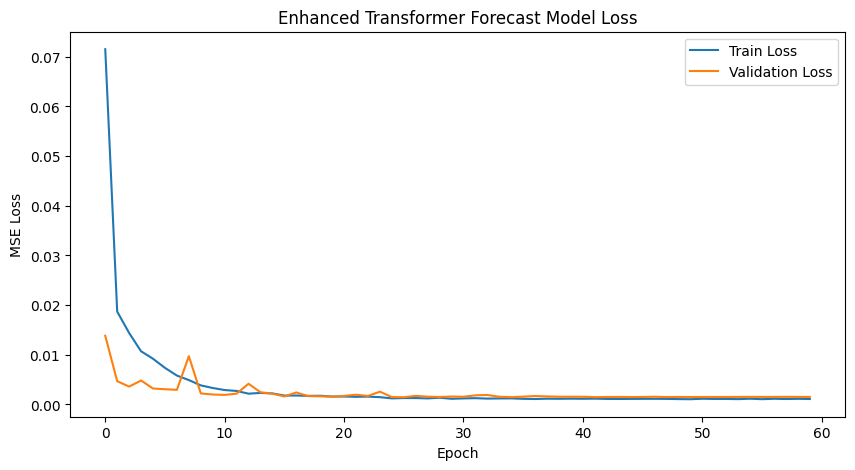

In [27]:
input_dim = X_train_scaled.shape[-1]
transformer_model = TransformerTimeSeries(
    input_dim=input_dim, # no. of input features
    d_model=256, # Dimensionality of embeddings
    nheads=8, # no. of attention heads for multi-head self-attention
    num_layers=3, # number of encoder layers
    dim_feedforward=512, # size of feedforward network in each encoder layer
    dropout=0.05 # percentage of dropout
).to(device)

forecast_lr = 1e-4
num_forecast_epochs = 60

optimizer = optim.Adam(transformer_model.parameters(), lr=forecast_lr) # Adam optimizer
criterion = nn.MSELoss() # MSE loss

# Reduces learning rate when validation loss plateaus, improving convergence.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                mode='min', # monitors for reduction
                                                factor=0.5, # Reduces lr by half when triggered
                                                patience=3, # waits 3 epochs without improvement before reducing lr
                                                verbose=True)

train_loss_history = []
val_loss_history = []

print("\nTraining the Enhanced Transformer Forecast model...")
for epoch in range(1, num_forecast_epochs+1):
    transformer_model.train() # Training mode
    running_train_loss = 0.0

    for batch_X, batch_y in train_forecast_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device) # Fetches batches of input (batch_X) and target (batch_y) and sends to device

        # Calculutes MSE loss between predictions and actual values
        optimizer.zero_grad()
        outputs = transformer_model(batch_X)

        # Computes gradients and updates model weights
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        # Caps gradient values to a max of 2 to stop exploding gradients
        nn.utils.clip_grad_norm_(transformer_model.parameters(), max_norm=2.0)

        running_train_loss += loss.item() * batch_X.size(0)

    epoch_train_loss = running_train_loss / len(train_forecast_loader.dataset)
    train_loss_history.append(epoch_train_loss)

    # Validation
    transformer_model.eval() # Evaluation model
    running_val_loss = 0.0
    with torch.no_grad(): # Avoids unnecessary calcs of gradients
        for batch_X, batch_y in test_forecast_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            val_outputs = transformer_model(batch_X) # Computes predictions on validation data
            val_loss = criterion(val_outputs, batch_y) # MSE loss for validation set
            running_val_loss += val_loss.item() * batch_X.size(0)

    epoch_val_loss = running_val_loss / len(test_forecast_loader.dataset)
    val_loss_history.append(epoch_val_loss)

    # Steps the scheduler to adjust learning rate
    scheduler.step(epoch_val_loss)

    # Debug
    print(f"Epoch [{epoch}/{num_forecast_epochs}] - "
          f"Train Loss: {epoch_train_loss:.6f}, "
          f"Val Loss: {epoch_val_loss:.6f}")

print("\nEnhanced Transformer forecast model training complete.")

# Plot
plt.figure(figsize=(10,5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title("Enhanced Transformer Forecast Model Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


After training we evalute the test data by generating predictions for the test set, converting the scaled predictions and target values back to original scale, and visualizing the predicted vs actual closing prices for test set.

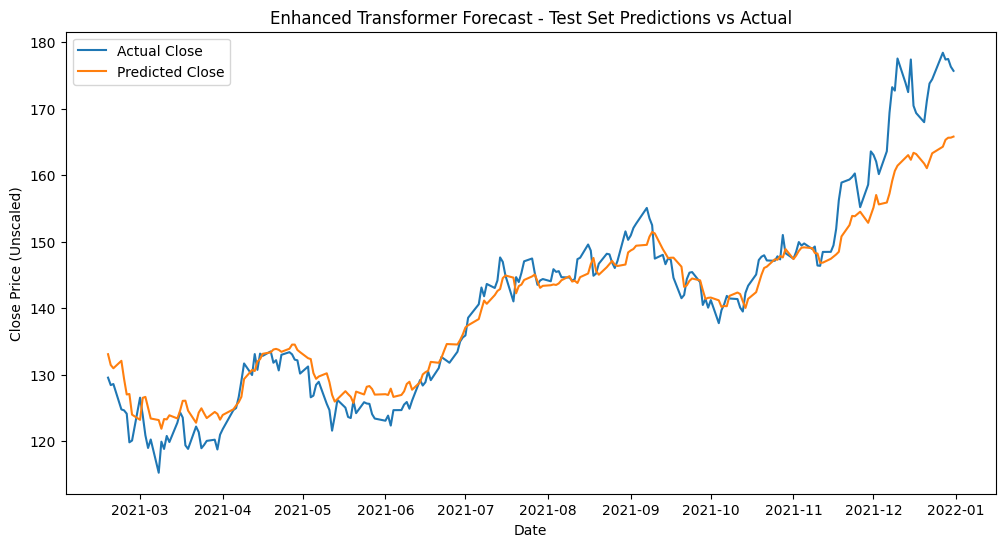

In [28]:
transformer_model.eval()

predictions_scaled = []
actuals_scaled = []

with torch.no_grad():
    for batch_X, batch_y in test_forecast_loader: # Loops through batches of test data
        batch_X = batch_X.to(device)
        batch_pred = transformer_model(batch_X) # predicts the scaled closing prices for each input batch
        predictions_scaled.extend(batch_pred.cpu().numpy()) # Predicted scale values
        actuals_scaled.extend(batch_y.cpu().numpy()) # Actual scaled target values

# Convert to numpy array
predictions_scaled = np.array(predictions_scaled)
actuals_scaled = np.array(actuals_scaled)

# Converts scaled values back to original scale using the inverse transformation of MinMaxScaler
def inverse_close_scale(values_scaled, scaler_obj, feature_index=3):
    dummy = np.zeros((len(values_scaled), X_train.shape[-1])) # Temp array with same no. of feature as training data
    for i in range(X_train.shape[-1]): # Broadcasts values_scaled across all feature columns
        dummy[:, i] = values_scaled
    dummy_inverted = scaler_obj.inverse_transform(dummy) # Inverse transformation to recover original scale
    return dummy_inverted[:, feature_index] # returns only the feature corresponding to close price

predictions_unscaled = inverse_close_scale(predictions_scaled, scaler, feature_index=3)
actuals_unscaled = inverse_close_scale(actuals_scaled, scaler, feature_index=3)

# Build a date range for the test targets
test_target_indices = np.arange(forecast_sequence_length, len(test_df))
test_target_dates = test_df.index[test_target_indices]

# Plot
plt.figure(figsize=(12,6))
plt.plot(test_target_dates, actuals_unscaled, label='Actual Close')
plt.plot(test_target_dates, predictions_unscaled, label='Predicted Close')
plt.xlabel("Date")
plt.ylabel("Close Price (Unscaled)")
plt.title("Enhanced Transformer Forecast - Test Set Predictions vs Actual")
plt.legend()
plt.show()

Finally a multi-step future forecasting is performed using trained enhanced transformer model.


--- Future Predictions (Enhanced Transformer) ---
Predicted Close on 2022-01-03: 165.28
Predicted Close on 2022-01-04: 164.27
Predicted Close on 2022-01-05: 164.18
Predicted Close on 2022-01-06: 164.16
Predicted Close on 2022-01-07: 164.18
Predicted Close on 2022-01-10: 164.20
Predicted Close on 2022-01-11: 164.24
Predicted Close on 2022-01-12: 164.27
Predicted Close on 2022-01-13: 164.31
Predicted Close on 2022-01-14: 164.33


<ipython-input-29-9fc2243c5446>:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_close = float(test_df['Close'].iloc[-1])


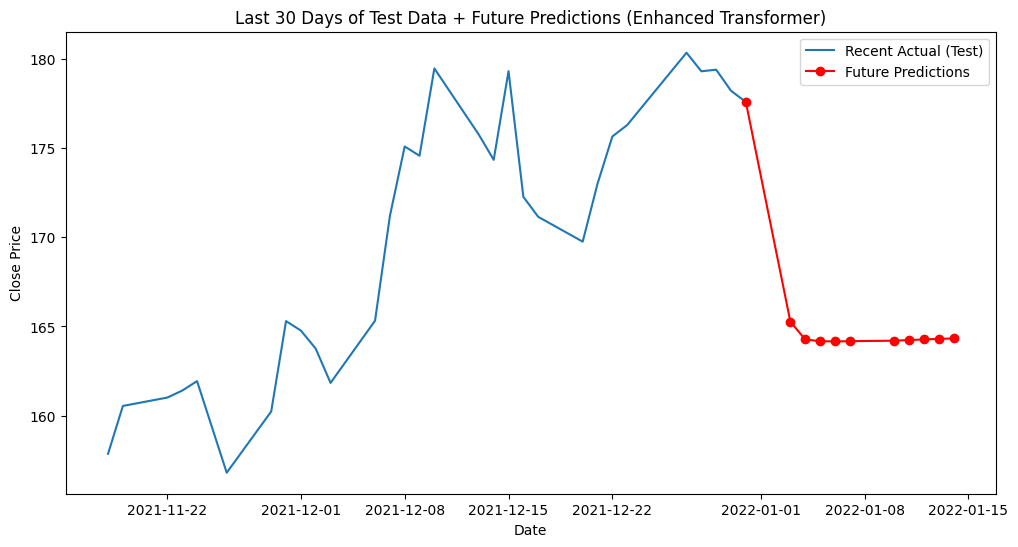

In [29]:
# Extracts most recent sequence from test set as starting point for forecasting
last_chunk = test_df[-forecast_sequence_length:].copy() # selects last rows from test_df
last_chunk_scaled = scaler.transform(last_chunk[feature_cols].values) # Scales features using MinMaxScaler (sequence_length, num_features)
last_chunk_torch = torch.tensor(last_chunk_scaled, dtype=torch.float32).unsqueeze(0).to(device) # Converts to pytorch tensor and adds batch dimension (1, sequence_length, num_features)

# Stores predictions for each day
future_preds = []

transformer_model.eval()

with torch.no_grad():
    current_sequence = last_chunk_torch.clone()
    for step in range(future_horizon):
        pred_scaled = transformer_model(current_sequence)  # pass current sequence through Transformer to predict next close price (1,)
        pred_scaled_val = pred_scaled.item()

        # invert scale
        pred_unscaled_val = inverse_close_scale(np.array([pred_scaled_val]), scaler, 3)[0] # maps scaled predictions back to original scale
        future_preds.append(float(pred_unscaled_val)) # adds unscaled prediction to future_preds

        # Extracts last time step and updates close feature with predicted value
        next_day = current_sequence[0, -1, :].cpu().numpy()
        next_day[3] = pred_scaled_val

        # shift the window one position to left so the oldest time step is removed and new day is added at the end
        next_sequence = torch.roll(current_sequence, shifts=-1, dims=1)
        next_sequence[0, -1, :] = torch.tensor(next_day, dtype=torch.float32)

        current_sequence = next_sequence

# Construct a date range for the future predictions
last_test_date = test_df.index[-1]
future_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1),
                             periods=future_horizon, freq='B')  # business days

# Plot
print("\n--- Future Predictions (Enhanced Transformer) ---")
for date, pred in zip(future_dates, future_preds):
    print(f"Predicted Close on {date.date()}: {pred:.2f}")

last_close = float(test_df['Close'].iloc[-1])
extended_dates = [last_test_date] + list(future_dates)
extended_prices = [last_close] + future_preds

plt.figure(figsize=(12,6))
plt.plot(test_df.index[-30:], test_df['Close'].iloc[-30:], label='Recent Actual (Test)')
plt.plot(extended_dates, extended_prices, marker='o', color='red', label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title("Last 30 Days of Test Data + Future Predictions (Enhanced Transformer)")
plt.legend()
plt.show()


# Strategy Code
Using recent anomalies detected and future price predictions we define a simple rule-based trading strategy that incorporates basic risk mitigation.

In [30]:

import numpy as np
import pandas as pd

Using a rule-based trading strategy we can provide buy, sell, or hold recommendations basedo n predicted price changes and recent anomalies. If the next day forecast is at least +2% higher than todays close we recommend buy, if its -2% we recommend sell, otherwise we recommend to hold.

In [32]:
def simple_trading_strategy(
    last_close_price,
    future_prices,
    anomalies_recent=None,
    buy_threshold=0.02,
    sell_threshold=-0.02
):

    recommendations = {} # Stores predictions, percentage differences and actions for each day

    if len(future_prices) > 0:
        # Extracts first future predicted price
        day1_pred = future_prices[0]

        # Calculuates percentage difference between predicted and actual prices
        pct_diff = (day1_pred - last_close_price) / last_close_price

        # If anomalies were detected, strategy becomes cautious
        if anomalies_recent:
            print("Recent anomaly detected => potential caution or adaptation in the strategy.")

        if pct_diff >= buy_threshold:
            action = "BUY"
        elif pct_diff <= sell_threshold:
            action = "SELL"
        else:
            action = "HOLD"

        # We hold after strategy selection to hold
        if anomalies_recent:
            action = "HOLD (due to anomaly caution)"

        recommendations["Day+1"] = {
            "Predicted_Close": day1_pred,
            "Pct_Diff": pct_diff,
            "Action": action
        }

    # Prediction for every remaining predicted price
    for i in range(1, len(future_prices)):
        day_str = f"Day+{i+1}"
        pred_close = future_prices[i]
        pct_diff = (pred_close - last_close_price) / last_close_price
        if pct_diff >= buy_threshold:
            action = "BUY"
        elif pct_diff <= sell_threshold:
            action = "SELL"
        else:
            action = "HOLD"

        if anomalies_recent:
            action = "HOLD (due to anomaly caution)"

        recommendations[day_str] = {
            "Predicted_Close": pred_close,
            "Pct_Diff": pct_diff,
            "Action": action
        }

    return recommendations

We then implement the logic for checking for recent anomalies

In [33]:
# In this case recent is defined as the last 5 days
recent_days_window = 5
recent_anomaly_found = False

test_length = len(test_df)
start_recent_idx = test_length - recent_days_window
if start_recent_idx < 0:
    start_recent_idx = 0

# for each anomaly index see if final_idx is in the last 5 days.
for seq_idx in anomaly_indices:
    final_idx = seq_idx + sequence_length - 1
    if final_idx >= start_recent_idx and final_idx < test_length:
        recent_anomaly_found = True
        break

print(f"\nRecent anomaly found (past {recent_days_window} days)? {recent_anomaly_found}")


Recent anomaly found (past 5 days)? False


Then we create a simple trading strategy.

In [34]:
recommendations = simple_trading_strategy(
    last_close_price=last_close,
    future_prices=future_preds,
    anomalies_recent=recent_anomaly_found,
    buy_threshold=0.02,   # if predicted price is >= 2% above last close => BUY
    sell_threshold=-0.02  # if predicted price is <= -2% below last close => SELL
)

print("\n--- Trading Strategy Recommendations ---")
for day, rec in recommendations.items():
    print(f"{day}: Predicted Close = {rec['Predicted_Close']:.2f}, "
          f"Pct Diff = {rec['Pct_Diff']:.2%}, "
          f"Action = {rec['Action']}")


--- Trading Strategy Recommendations ---
Day+1: Predicted Close = 165.28, Pct Diff = -6.92%, Action = SELL
Day+2: Predicted Close = 164.27, Pct Diff = -7.49%, Action = SELL
Day+3: Predicted Close = 164.18, Pct Diff = -7.54%, Action = SELL
Day+4: Predicted Close = 164.16, Pct Diff = -7.55%, Action = SELL
Day+5: Predicted Close = 164.18, Pct Diff = -7.54%, Action = SELL
Day+6: Predicted Close = 164.20, Pct Diff = -7.53%, Action = SELL
Day+7: Predicted Close = 164.24, Pct Diff = -7.51%, Action = SELL
Day+8: Predicted Close = 164.27, Pct Diff = -7.49%, Action = SELL
Day+9: Predicted Close = 164.31, Pct Diff = -7.47%, Action = SELL
Day+10: Predicted Close = 164.33, Pct Diff = -7.46%, Action = SELL


Finally, we consider volatility and anomalies to place stop-losses etc.

In [35]:
risk_mitigation = {}
volatility_margin = 0.03  # 3% stop-loss margin

if recommendations:
    # Let's say we only do a stop-loss if we plan to BUY
    for day, rec in recommendations.items():
        if "BUY" in rec["Action"]:
            stop_loss_price = last_close * (1.0 - volatility_margin)
            risk_mitigation[day] = {
                "Stop Loss Price": stop_loss_price,
                "Reason": "Place a stop-loss 3% below the last close to mitigate downside risk."
            }
        elif "HOLD" in rec["Action"]:
            risk_mitigation[day] = {
                "Adjustment": "Monitor closely",
                "Reason": "Model suggests hold; watch for future anomalies."
            }
        elif "SELL" in rec["Action"]:
            risk_mitigation[day] = {
                "Recommendation": "Take partial or full exit from position",
                "Reason": "Transformer predicts a drop greater than 2%. Possibly reduce exposure."
            }

print("\n--- Risk Mitigation Strategy ---")
for day, info in risk_mitigation.items():
    print(f"{day} -> {info}")


--- Risk Mitigation Strategy ---
Day+1 -> {'Recommendation': 'Take partial or full exit from position', 'Reason': 'Transformer predicts a drop greater than 2%. Possibly reduce exposure.'}
Day+2 -> {'Recommendation': 'Take partial or full exit from position', 'Reason': 'Transformer predicts a drop greater than 2%. Possibly reduce exposure.'}
Day+3 -> {'Recommendation': 'Take partial or full exit from position', 'Reason': 'Transformer predicts a drop greater than 2%. Possibly reduce exposure.'}
Day+4 -> {'Recommendation': 'Take partial or full exit from position', 'Reason': 'Transformer predicts a drop greater than 2%. Possibly reduce exposure.'}
Day+5 -> {'Recommendation': 'Take partial or full exit from position', 'Reason': 'Transformer predicts a drop greater than 2%. Possibly reduce exposure.'}
Day+6 -> {'Recommendation': 'Take partial or full exit from position', 'Reason': 'Transformer predicts a drop greater than 2%. Possibly reduce exposure.'}
Day+7 -> {'Recommendation': 'Take pa